# A less-simple example doing Bayesian inference for a harmonic oscillator

This example assumes that the times of measurements are not
errror-free and thus are parameters as well.  I assume here that the
`ts_measured` are at the times when the measurements are supposed to
be taken (thus at regular intervals in this setup), but that the
actual time of measurement was at a different time.

  0.000004 seconds (148 allocations: 10.151 KB)


    +(AbstractArray, DataArrays.DataArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /home/mauro/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home/mauro/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


[Plots.jl] Initializing backend: pyplot



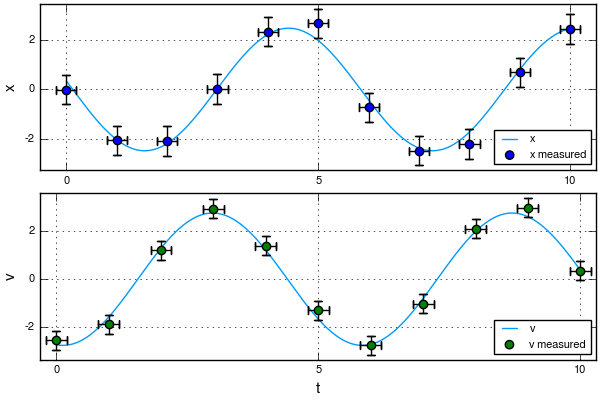

In [1]:
# this is where the forward model, probabilistic model etc are defined.
using NBInclude
nbinclude("bayesian-ex-base.ipynb")
using Plots,StatPlots # this works only up to StatPlots 9e665438 & on 0.5 of PyCall too (14 July 2016)
@time 1 # warmup

# choose to use the analytic or ODE-forward model
fwd! = [fwd_ana!, fwd_ode!][1]

# make the synthetic measurements
sigma_x = 0.3
sigma_v = 0.2
sigma_t = 0.1
const ts_measured, xv_measured, A, ω, ϕ, ts_true, xv_true = make_synthetic_measurements(theta_true = [2.5, 1.1, 3], # [A, ω, ϕ]
                                                             sigma_x=sigma_x,
                                                             sigma_v=sigma_v,
                                                             sigma_t=sigma_t)
@assert !all(ts_measured.==ts_true)

## Plot the measurements
plotmeasurements(ts_measured,xv_measured,A,ω,ϕ,sigma_x=sigma_x,sigma_v=sigma_v,sigma_t=sigma_t)

## Probabilistic model setup

Fitting parameters `[A,ω,ϕ,sigma_x,sigma_v,sigma_t,ts] = theta`

In [2]:
varnames = vcat(["A","ω",  "ϕ",  "σ_x", "σ_v", "σ_t"], ["t$i" for i=1:length(ts_measured)])

# convenince method to extract ts from theta
getts(theta) = view(theta, 7:length(ts_measured)+6)

const fwdout = init_fwd(ts_measured) # Note, this will be modified in place
# Treat ts as measurements too
function loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
    out = zero(err1(xv_measured[1], fwdout[1]))
    N = length(xv_measured)

    # Note the normalization term 1/2*log(2*pi*sigma^2) needs to
    # be included when sigma is also a fitting parameter.
    for i=1:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_x^2) + log(2*pi*sigma_x^2)
    end
    for i=2:2:N
        out -= err1(xv_measured[i], fwdout[i])/(sigma_v^2) + log(2*pi*sigma_v^2)
    end
    # treat time as measurements too
    for i=1:length(ts)
        out -= err1(ts_measured[i], ts[i])/(sigma_t^2) + log(2*pi*sigma_t^2)
    end
    return out/2
end


# Likelilhood

function loglikelihood(theta)
    # Closure over fwdout, fwd!, xv_measured, ts_measured
    # make sure those are `const`!
    A,ω,ϕ,sigma_x,sigma_v,sigma_t = theta
    ts = getts(theta)
    fwd!(fwdout, ts, A,ω,ϕ)
    loglikelihood(fwdout, ts, xv_measured, ts_measured, sigma_x,sigma_v,sigma_t)
end

# Normal & uniform priors
logprior_A(A) = 0<=A ? 0.0 : -Inf # amplitude is positive
ω_max = 15.0
logprior_ω(ω) = 0<=ω<ω_max ? 0.0 : -Inf # ω is bounded
logprior_ϕ(ϕ) = 0<=ϕ<2*pi ? 0.0 : -Inf # ϕ is bounded

sigma_x_est = 0.2 # our prior estimate of sigma_x
sigma_est_sigma_x = 0.2 # our estimate of the std of sigma_x
logprior_sigma_x(sigma_x) = sigma_x<=0 ? -Inf : -(sigma_x-sigma_x_est)^2/(2*sigma_est_sigma_x^2)

sigma_v_est = 0.2 # our prior estimate of sigma_v
sigma_est_sigma_v = 0.2 # our estimate of the std of sigma_v
logprior_sigma_v(sigma_v) = sigma_v<=0 ? -Inf : -(sigma_v-sigma_v_est)^2/(2*sigma_est_sigma_v^2)

sigma_t_est = 0.05 # our prior estimate of sigma_t
sigma_est_sigma_t = 0.05 # our estimate of the std of sigma_t
logprior_sigma_t(sigma_t) = sigma_t<=0 ? -Inf : -(sigma_t-sigma_t_est)^2/(2*sigma_est_sigma_t^2)

# sum of priors for ts
function logpriors_ts(ts)
    out = 0.0
    for i=1:length(ts)
        out -= (ts[i]-ts_measured[i])^2/(2*sigma_t_est^2)
    end
    return out
end


logprior = (theta) -> (logprior_A(theta[1]) +
                       logprior_ω(theta[2]) +
                       logprior_ϕ(theta[3]) +
                       logprior_sigma_x(theta[4]) +
                       logprior_sigma_v(theta[5]) +
                       logprior_sigma_t(theta[6]) +
                       logpriors_ts(getts(theta))
                       )

# This will be estimated:
logposterior = @anon theta -> loglikelihood(theta) + logprior(theta);

## MCMC fitting

First define some parameters. Generally `_m` referes to variables connected to the Metropolis sampler, `_e` to the `emcee` sampler.

In [3]:
niter = 5*10^5 # number of MC steps
nthin = 10     # only store theta every so often
nburnin = niter÷3 # how much burn-in
nchains = 50 # number of chains used in the emcee sampler
niter_e = niter÷nchains # iterations in the emcee sampler reduced accordingly
nburnin_e = niter_e÷3; # burnin

3333

In [4]:
#################
# Metropolis MCMC
#################

# Using a Gaussian proposal distribution.  Note, this needs to be
# symmetric for Metropolis!

sig = 0.002  # this needs tuning, accept_ratio of 1/4 is good, they say.
const sigma_ppdf = sig*ones(6+length(ts_measured))
sample_ppdf(theta) = [randn()*sigma_ppdf[i]+theta[i] for i=1:length(theta)]

theta_true = vcat([A, ω, ϕ, sigma_x, sigma_v, sigma_t], ts_measured);  # good IC
theta0 = vcat([2.1, 1.1, 1.1, 0.2, 0.2, 0.05], ts_measured); # decent IC

metropolis(logposterior, sample_ppdf, theta0, niter=2)
print("Metropolis: ")
@time thetas_m, accept_ratio_m = metropolis(logposterior, sample_ppdf, theta0,
                                            niter=niter, nthin=nthin, nburnin=nburnin)
print_results(thetas_m, accept_ratio_m, names=varnames, title="Metropolis", theta_true=theta_true)

Metropolis:   3.141256 seconds (56.52 M allocations: 1.003 GB, 3.68% gc time)
Metropolis
Ratio of accepted/total steps: 0.5751048497903004

var 	 err	median	 mean 	 mode 	 std
A 	 0.12 	 2.62 	 2.62 	 2.65 	 0.07
ω 	 0.0 	 1.1 	 1.1 	 1.09 	 0.01
ϕ 	 0.02 	 2.98 	 2.98 	 3.01 	 0.06
σ_x 	 0.02 	 0.28 	 0.29 	 0.24 	 0.06
σ_v 	 0.01 	 0.21 	 0.21 	 0.23 	 0.06
σ_t 	 0.09 	 0.01 	 0.02 	 0.0 	 0.01
t1 	 0.0 	 0.0 	 0.0 	 0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 2.0 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.01
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.01
t6 	 0.0 	 5.0 	 4.99 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 6.0 	 6.0 	 0.02
t8 	 0.0 	 7.0 	 7.0 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 8.0 	 8.0 	 0.02
t10 	 0.0 	 9.0 	 9.0 	 9.0 	 0.02
t11 	 0.0 	 10.0 	 10.0 	 10.0 	 0.02



In [5]:
#################
# emcee MCMC
#################

emcee(logposterior, (theta0, 0.1), niter=10, nchains=2)
print("emcee:")
@time thetas_ec, accept_ratio_ec = emcee(logposterior, (theta0, 0.1),
                                         niter=niter_e, nthin=nthin, nchains=nchains, nburnin=nburnin_e)
thetas_e, accept_ratio_e = squash_chains(thetas_ec, accept_ratio_ec, drop_low_accept_ratio=true)
# when using emcee with IC far from the optimum, then it produces unconverged chains
print_results(thetas_e, accept_ratio_e, names=varnames, title="emcee", theta_true=theta_true)

emcee:  3.649284 seconds (59.92 M allocations: 1.233 GB, 4.07% gc time)
Dropping low accept-ratio chain 9
Dropping low accept-ratio chain 16
Dropping low accept-ratio chain 18
Dropping low accept-ratio chain 19
Dropping low accept-ratio chain 22
Dropping low accept-ratio chain 27
Dropping low accept-ratio chain 31
Dropping low accept-ratio chain 37
emcee
Ratio of accepted/total steps: 0.3136128907840322

var 	 err	median	 mean 	 mode 	 std
A 	 0.11 	 2.61 	 2.62 	 2.59 	 0.07
ω 	 0.0 	 1.1 	 1.1 	 1.1 	 0.01
ϕ 	 0.04 	 2.96 	 2.96 	 2.98 	 0.06
σ_x 	 0.01 	 0.29 	 0.3 	 0.3 	 0.07
σ_v 	 0.0 	 0.2 	 0.21 	 0.19 	 0.06
σ_t 	 0.08 	 0.02 	 0.02 	 0.01 	 0.01
t1 	 0.0 	 0.0 	 0.0 	 -0.0 	 0.02
t2 	 0.0 	 1.0 	 1.0 	 1.0 	 0.02
t3 	 0.0 	 2.0 	 2.0 	 2.0 	 0.02
t4 	 0.0 	 3.0 	 3.0 	 3.0 	 0.02
t5 	 0.0 	 4.0 	 4.0 	 4.0 	 0.02
t6 	 0.01 	 4.99 	 4.99 	 5.0 	 0.02
t7 	 0.0 	 6.0 	 6.0 	 6.0 	 0.02
t8 	 0.0 	 7.0 	 7.0 	 7.0 	 0.02
t9 	 0.0 	 8.0 	 8.0 	 8.0 	 0.02
t10 	 0.0 	 9.0 	 9.0 	 9.

Output evaluation: plot the 1D and 2D distributions in a corner-plot (excluding some of the `ts` parameters).  Note that all the parameters are well estimated, **excpet $\sigma_t$** (not sure why that fails).  The std-deviation of the parameters depends on how much error the synthetic data contains.  $\omega$ and $\phi$ are anti-correlated, the rest are un-correlated.


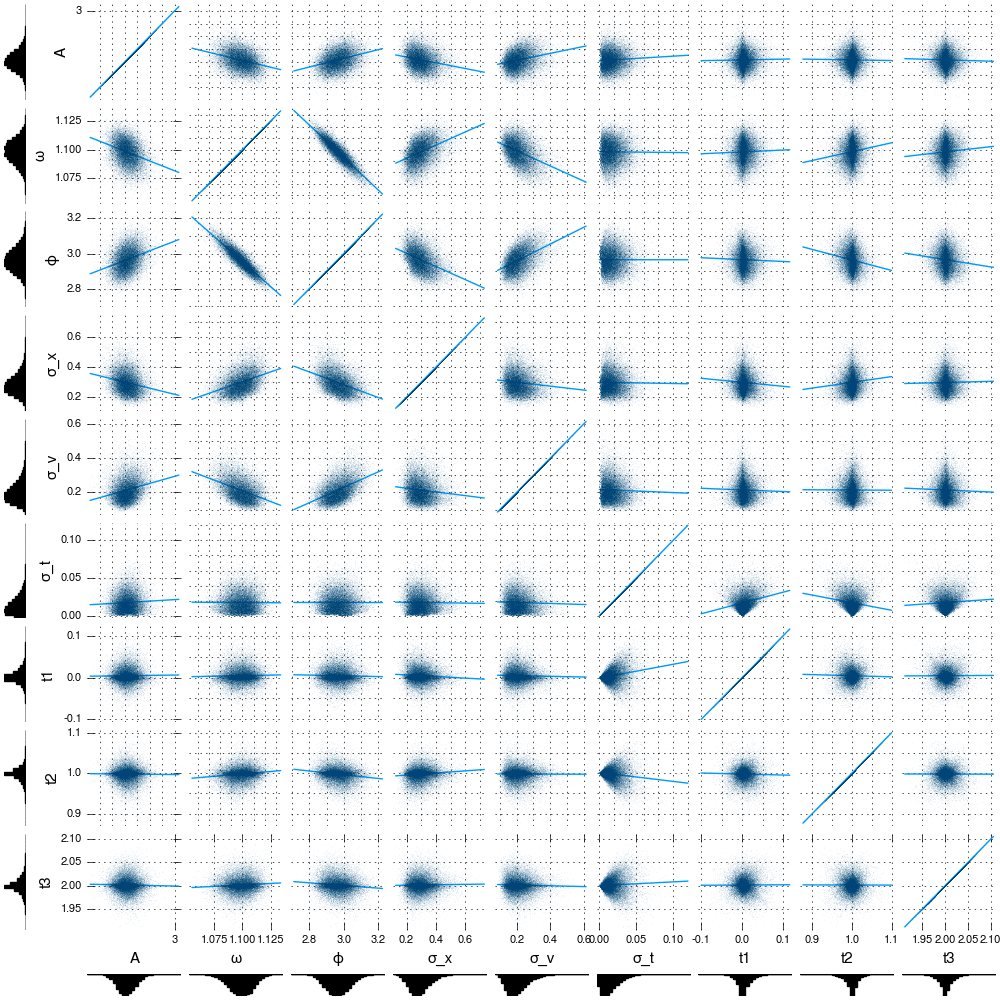

In [6]:
np=9
cornerplot(thetas_e[1:np,:]', label=varnames[1:np], size=(1000,1000))